# Preprocessing

Objectives:
- Load interim cleaned spatial and time-series datasets
- Construct a 4D ML-ready dataset (x, y, z, t)
- Interpolate missing timesteps or spatial points
- Add physics-informed features for surrogate modeling
- Save the preprocessed dataset for downstream ML tasks

**Source:** Society of Petroleum Engineers (SPE)  
**Dataset:** SPE Comparative Solution Project - Model 11C (3D CO₂ Injection)

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

INTERIM = Path(r"C:\Users\tetec\Documents\Data Project Coding\.vscode\Project data\spe11c\data\interim\cleaned")
PROCESSED = Path(r"C:\Users\tetec\Documents\Data Project Coding\.vscode\Project data\spe11c\data\processed")
PROCESSED.mkdir(parents=True, exist_ok=True)

print(f"Processed folder is ready at: {PROCESSED.resolve()}")

spatial_all = pd.read_parquet(INTERIM / 'spatial_all.parquet')
timeseries = pd.read_parquet(INTERIM / 'timeseries.parquet')

print('Spatial data shape:', spatial_all.shape)
print('Time-series data shape:', timeseries.shape)

Processed folder is ready at: C:\Users\tetec\Documents\Data Project Coding\.vscode\Project data\spe11c\data\processed
Spatial data shape: (52416000, 12)
Time-series data shape: (10001, 14)


In [3]:
# Remove inactive cells
spatial_active = spatial_all[spatial_all['pressure [Pa]'] > 0].copy()
print('Active cells shape:', spatial_active.shape)

Active cells shape: (52416000, 12)


In [4]:
# Target years for interpolation
target_years = np.arange(spatial_active['year'].min(), spatial_active['year'].max()+1)

grid_x = np.unique(spatial_active[' x [m]'])
grid_y = np.unique(spatial_active['y [m]'])
grid_z = np.unique(spatial_active['z [m]'])

In [5]:
# interpolation function
def interpolate_4d_pressure(spatial_df, target_years, grid_x, grid_y, grid_z):
    ml_data_list = []
    points = spatial_df[[' x [m]', 'y [m]', 'z [m]', 'year']].values
    values = spatial_df['pressure [Pa]'].values


    for yr in target_years:
        xx, yy, zz = np.meshgrid(grid_x, grid_y, grid_z, indexing='ij')
        zz_interp = griddata(points, values, (xx, yy, zz, yr), method='linear')
        ml_data_list.append(pd.DataFrame({
            ' x [m]': xx.flatten(),
            'y [m]': yy.flatten(),
            'z [m]': zz.flatten(),
            'year': yr,
            'pressure [Pa]': zz_interp.flatten()
        }))
    ml_data = pd.concat(ml_data_list, ignore_index=True)
    return ml_data

In [7]:
print(sorted(spatial_active['year'].unique()))

[np.int64(0), np.int64(5), np.int64(10), np.int64(15), np.int64(20), np.int64(25), np.int64(30), np.int64(35), np.int64(40), np.int64(45), np.int64(50), np.int64(75), np.int64(100), np.int64(150), np.int64(200), np.int64(250), np.int64(300), np.int64(350), np.int64(400), np.int64(450), np.int64(500), np.int64(600), np.int64(700), np.int64(800), np.int64(900), np.int64(1000)]


In [14]:
from scipy.interpolate import RegularGridInterpolator

target_years_small = np.array(sorted(spatial_active['year'].unique()))
print("Using target years:", target_years_small)
print("Total years:", len(target_years_small))

# Define 3D output grid 
grid_x = np.linspace(spatial_active[' x [m]'].min(), spatial_active[' x [m]'].max(), 20)
grid_y = np.linspace(spatial_active['y [m]'].min(), spatial_active['y [m]'].max(), 20)
grid_z = np.linspace(spatial_active['z [m]'].min(), spatial_active['z [m]'].max(), 10)

# Output array
ml_data = np.empty((len(grid_x), len(grid_y), len(grid_z), len(target_years_small)))

# Precompute target mesh 
XX, YY, ZZ = np.meshgrid(grid_x, grid_y, grid_z, indexing='ij')
target_points = np.stack([XX.ravel(), YY.ravel(), ZZ.ravel()], axis=-1)

# Loop through all years and interpolate
for i, yr in enumerate(target_years_small):

    # Find bounding simulation years
    lower_candidates = spatial_active['year'][spatial_active['year'] <= yr]
    upper_candidates = spatial_active['year'][spatial_active['year'] >= yr]

    if lower_candidates.empty or upper_candidates.empty:
        print(f"Warning: No bounding years for target {yr}. Skipping.")
        continue

    lower_year = lower_candidates.max()
    upper_year = upper_candidates.min()

    # Fetch slices
    slice_lower = spatial_active[spatial_active['year'] == lower_year]
    slice_upper = spatial_active[spatial_active['year'] == upper_year]

    if slice_lower.empty or slice_upper.empty:
        print(f"Warning: Empty slice at {yr}. Skipped.")
        continue

    # Coordinates in each slice
    x_l, y_l, z_l = np.unique(slice_lower[' x [m]']), np.unique(slice_lower['y [m]']), np.unique(slice_lower['z [m]'])
    x_u, y_u, z_u = np.unique(slice_upper[' x [m]']), np.unique(slice_upper['y [m]']), np.unique(slice_upper['z [m]'])

    # 3D pressure arrays
    p_lower = slice_lower.pivot_table(index=' x [m]', columns=['y [m]', 'z [m]'], values='pressure [Pa]').values \
                      .reshape(len(x_l), len(y_l), len(z_l))

    p_upper = slice_upper.pivot_table(index=' x [m]', columns=['y [m]', 'z [m]'], values='pressure [Pa]').values \
                      .reshape(len(x_u), len(y_u), len(z_u))

    # Build interpolators (3D)
    interp_lower = RegularGridInterpolator((x_l, y_l, z_l), p_lower, bounds_error=False, fill_value=None)
    interp_upper = RegularGridInterpolator((x_u, y_u, z_u), p_upper, bounds_error=False, fill_value=None)

    # Interpolate
    vals_lower = interp_lower(target_points)
    vals_upper = interp_upper(target_points)

    # Time interpolation
    if lower_year == upper_year:
        vals = vals_lower
    else:
        t = (yr - lower_year) / (upper_year - lower_year)
        vals = vals_lower + (vals_upper - vals_lower) * t

    # Store
    ml_data[:, :, :, i] = vals.reshape(len(grid_x), len(grid_y), len(grid_z))

print("ML-ready 4D dataset shape:", ml_data.shape)

Using target years: [   0    5   10   15   20   25   30   35   40   45   50   75  100  150
  200  250  300  350  400  450  500  600  700  800  900 1000]
Total years: 26
ML-ready 4D dataset shape: (20, 20, 10, 26)


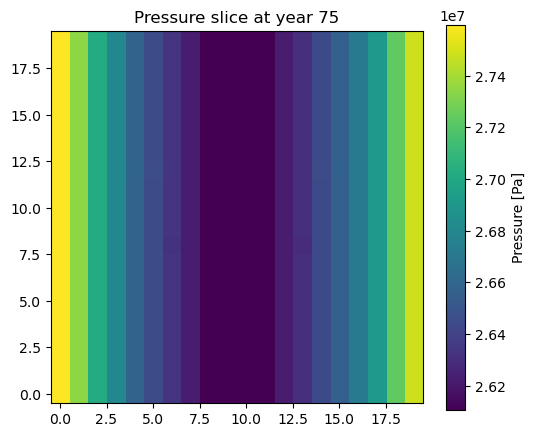

In [15]:
sample_year = 75

# find matching year index in the ML tensor
year_idx = np.where(target_years_small == sample_year)[0][0]

# extract the corresponding 3D grid
volume = ml_data[:, :, :, year_idx]

# pick middle z slice
z_mid = volume.shape[2] // 2
z_slice = volume[:, :, z_mid]

plt.figure(figsize=(6,5))
plt.imshow(z_slice, origin='lower')
plt.colorbar(label="Pressure [Pa]")
plt.title(f"Pressure slice at year {sample_year}")
plt.show()



In [16]:
# Save ml ready data
np.save(PROCESSED / "ml_ready_4D_dataset.npy", ml_data)
print("Saved as .npy file")

Saved as .npy file
